In [2]:
# import sys
# !conda install --yes --prefix {sys.prefix} numpy
# !conda install --yes --prefix {sys.prefix} tensorflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline
tf.__version__


/Users/Anas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.13.1'

In [3]:
curr_dir = os.getcwd()
curr_dir

'/Users/Anas/Documents/Grab'

In [4]:
train_data = pd.read_hdf('train_data.h5', 'grabai')
train_data.Speed = train_data.Speed.replace(-1,np.NaN)
test_data = pd.read_hdf('val_data.h5', 'grabai')
test_data.Speed = test_data.Speed.replace(-1,np.NaN)

# Simple fillna would do as only 1.5% of data is missing
train_data.Speed.fillna(train_data.Speed.median(), inplace=True)
test_data.Speed.fillna(test_data.Speed.median(), inplace=True)

In [5]:
train_data.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,1099511627891,3.000,311.0,0.452518,9.273026,3.098191,0.005382,0.002155,-0.001436,66.0,0.340365,0
1,1099511627891,3.695,311.0,0.047885,9.404712,2.834821,-0.299440,-0.062597,-0.006934,41.0,0.000000,0
2,1099511627891,3.000,271.0,0.438152,9.263450,3.004815,-0.079529,0.048581,-0.009377,558.0,0.000000,0
3,1099511627891,3.777,313.0,0.469278,9.196409,3.023969,-0.011112,0.014372,-0.009377,824.0,0.000000,0
4,1099511627891,3.692,311.0,0.411815,9.263450,3.071855,-0.044098,0.027811,-0.006323,45.0,0.000000,0


In [6]:
(train_data == 0).sum()
# The zeros will be pose a problem when calculating 

bookingID            1004
Accuracy                0
Bearing            689308
acceleration_x      11125
acceleration_y        335
acceleration_z       3257
gyro_x              32354
gyro_y              29815
gyro_z              36375
second              14041
Speed             1957809
label             7806095
dtype: int64

### Notes
<div style="width: 400px; float: right;">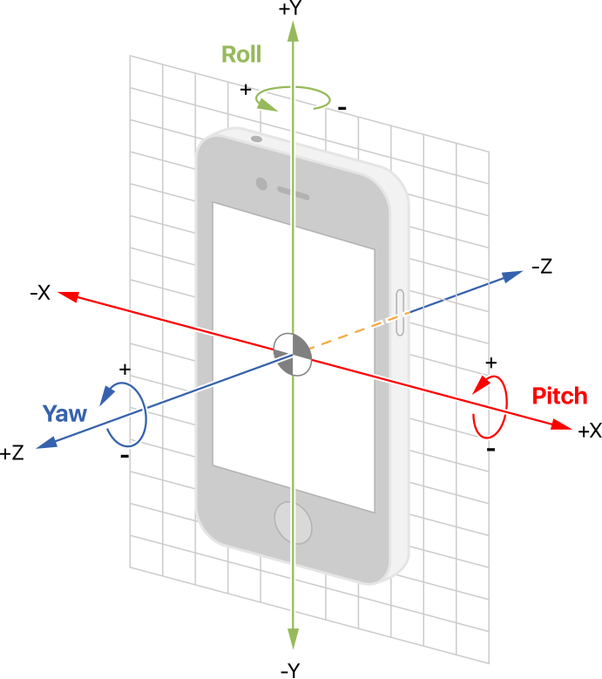</div>
#### Acceleration
* Acceleration X shows acceleration on the left or right (if value more than 0, it is a left turn)
* Accelleration Y is shows acceleration on the up down axis (due to gravity, default will be -9.81, therefore if value more than -9.81, then the vehicle/phone is down)
* Axeleration Z is the forward and backward acceleration (if less than 0, it is foreward acceleration. This will be the case most of the time)

#### Gyro
* Gyro X rotation along the X axis (pitch). Positive value refers to a left tilt on the X axis.
* Gyro Y rotation along the Y axis (roll). Positive value refers to a left tilt on the Y axis.
* Gyro Z rotation along the Z axis (yaw). Positive value refers to a left tilt on the Z axis.

#### Interpretation
* A left/right turn will have change in acceleration along the X axis, while changing the Roll(gyro Y axis). The larger the gyro Y value the sharper the turn.
* A up/down movement will have change in acceleration along the Y axis, while changing the Pitch(gyro X axis). The larger the gyro X value the steeper the slope.
* When there is a combination of left/right and up/down or the road is tilted, the Yaw(gyro Z axis) will change. The value represents shows if it is a right(positive) or left(negative) tilt.

In [7]:
def add_features(df):
    # this function adds the direction, smoothness and intensity for each data point
    # Direction
    df['up'] = df.acceleration_y.apply(lambda y: 1 if np.round(y,2)+9.81 < 0 else 0)
    df['down'] = df.acceleration_y.apply(lambda y: 1 if np.round(y,2)+9.81 > 0 else 0)
    
    df['right'] = df.acceleration_x.apply(lambda x: 1 if np.round(x,2) < 0 else 0)
    df['left'] = df.acceleration_x.apply(lambda x: 1 if np.round(x,2) > 0 else 0)
    
    # Though the else value for smoothness and intensity is not technically correct, 
    # it should help to create some noise that will improve generalization
    # Smoothness
    df['rl_smooth'] = np.where((df.Speed!=0) & (df.gyro_y!=0),
                               df.Speed/np.abs(df.gyro_y),
                               df.Speed + np.abs(df.gyro_y)) # right left smoothness
    
    df['ud_smooth'] = np.where((df.Speed!=0) & (df.gyro_x!=0),
                               df.Speed/np.abs(df.gyro_x),
                               df.Speed + np.abs(df.gyro_x)) # up down smoothness
    
    df['smoothness'] = np.sqrt(np.square(df.rl_smooth) + np.square(df.ud_smooth))
    
    # Intensity
    df['rl_intensity'] = np.where(df.acceleration_x != 0, 
                                  df.rl_smooth * np.abs(df.acceleration_x), 
                                  df.rl_smooth)
    df['ud_intensity'] = np.where(df.acceleration_x != 0, 
                                  df.ud_smooth * np.abs(df.acceleration_y), 
                                  df.ud_smooth)
    df['intensity'] = np.sqrt(np.square(df.rl_intensity) + np.square(df.ud_intensity))
    
    df_col = list(df)
    df_col.remove('label')
    df_col.append('label')
    
    return df[df_col]

In [8]:
if os.path.isfile('train_data_features.h5'):
    train_data = pd.read_hdf('train_data_features.h5', 'grabai')
    test_data = pd.read_hdf('val_data_features.h5', 'grabai')
else:
    train_data = add_features(train_data)
    test_data = add_features(test_data)
    
    train_data.to_hdf('train_data_features.h5', 'grabai')
    test_data.to_hdf('val_data_features.h5', 'grabai')

train_data.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,...,down,right,left,rl_smooth,ud_smooth,smoothness,rl_intensity,ud_intensity,intensity,label
0,1099511627891,3.000,311.0,0.452518,9.273026,3.098191,0.005382,0.002155,-0.001436,66.0,...,1,0,1,157.932496,63.244702,170.125147,71.467286,586.469771,590.808230,0
1,1099511627891,3.695,311.0,0.047885,9.404712,2.834821,-0.299440,-0.062597,-0.006934,41.0,...,1,0,1,0.062597,0.299440,0.305913,0.002997,2.816147,2.816149,0
2,1099511627891,3.000,271.0,0.438152,9.263450,3.004815,-0.079529,0.048581,-0.009377,558.0,...,1,0,1,0.048581,0.079529,0.093193,0.021286,0.736709,0.737016,0
3,1099511627891,3.777,313.0,0.469278,9.196409,3.023969,-0.011112,0.014372,-0.009377,824.0,...,1,0,1,0.014372,0.011112,0.018167,0.006745,0.102187,0.102410,0
4,1099511627891,3.692,311.0,0.411815,9.263450,3.071855,-0.044098,0.027811,-0.006323,45.0,...,1,0,1,0.027811,0.044098,0.052136,0.011453,0.408503,0.408663,0


In [9]:
from sklearn.preprocessing import Normalizer
if os.path.isfile('train_data_features.h5'):
    train_data = pd.read_hdf('train_data_norm.h5', 'grabai')
    test_data = pd.read_hdf('val_data_norm.h5', 'grabai')
else:
    cols = list(train_data)
    cols.remove('label')
    cols.remove('bookingID')

    scaler = Normalizer()
    scaler = scaler.fit(train_data[cols])
    train_data[cols] = scaler.transform(train_data[cols])
    test_data[cols] = scaler.transform(test_data[cols])
    
    train_data.to_hdf('train_data_norm.h5', 'grabai')
    test_data.to_hdf('val_data_norm.h5', 'grabai')

train_data.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,...,down,right,left,rl_smooth,ud_smooth,smoothness,rl_intensity,ud_intensity,intensity,label
0,1099511627891,0.003240,0.335912,0.000489,0.010016,0.003346,0.000006,0.000002,-0.000002,0.071287,...,0.001080,0.0,0.001080,0.170583,0.068311,0.183752,0.077192,0.633447,0.638133,0
1,1099511627891,0.011771,0.990776,0.000153,0.029961,0.009031,-0.000954,-0.000199,-0.000022,0.130617,...,0.003186,0.0,0.003186,0.000199,0.000954,0.000975,0.000010,0.008972,0.008972,0
2,1099511627891,0.004835,0.436806,0.000706,0.014931,0.004843,-0.000128,0.000078,-0.000015,0.899401,...,0.001612,0.0,0.001612,0.000078,0.000128,0.000150,0.000034,0.001187,0.001188,0
3,1099511627891,0.004285,0.355074,0.000532,0.010433,0.003430,-0.000013,0.000016,-0.000011,0.934762,...,0.001134,0.0,0.001134,0.000016,0.000013,0.000021,0.000008,0.000116,0.000116,0
4,1099511627891,0.011742,0.989136,0.001310,0.029462,0.009770,-0.000140,0.000088,-0.000020,0.143123,...,0.003181,0.0,0.003181,0.000088,0.000140,0.000166,0.000036,0.001299,0.001300,0


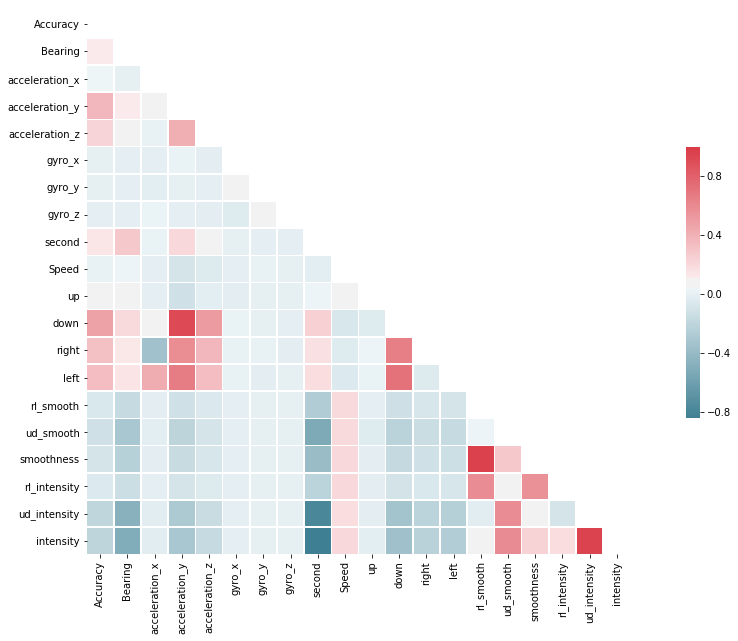

In [10]:
cols = list(train_data)
cols.remove('bookingID')
cols.remove('label')
plt.figure(figsize=(20,10))
corr = train_data[cols].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
t = train_data.head(2000).groupby('bookingID')

In [12]:
t = t.sum()
t.columns = list(map(lambda x: x + '_mean', list(t)))
t

,Accuracy_mean,Bearing_mean,acceleration_x_mean,acceleration_y_mean,acceleration_z_mean,gyro_x_mean,gyro_y_mean,gyro_z_mean,second_mean,Speed_mean,...,down_mean,right_mean,left_mean,rl_smooth_mean,ud_smooth_mean,smoothness_mean,rl_intensity_mean,ud_intensity_mean,intensity_mean,label_mean
bookingID,,,,,,,,,,,,,,,,,,,,,
962072674446,3.024428,53.263233,0.079637,-2.617704,-1.325225,-0.006598,-0.000334,0.000804,279.451579,2.527747,...,0.291030,0.058678,0.239923,120.424356,91.400138,171.156025,44.301833,781.508702,789.970152,0
1099511627891,2.614201,150.124104,0.151765,5.549768,1.698244,-0.001512,-0.003291,-0.002302,271.053324,2.787516,...,0.593083,0.123641,0.466721,57.876378,39.033900,79.574525,35.322554,356.271898,365.279875,0


In [13]:
def grouped_data(df):
    extra_features = []
    all_cols = list(df)
    cols = all_cols
    cols.remove('bookingID')
    cols.remove('label')
    
    grouped = df.groupby('bookingID')
    lst_functions = ['mean', 'median', 'min', 'max', 'std', 'skew', 'count', 'sum']
    for func in lst_functions:
        if func == 'mean':
            temp = grouped.mean()
            temp.columns = list(map(lambda x: x + '_mean', list(temp)))
            extra_features.append(temp)
            
        if func == 'median':
            temp = grouped.median()
            temp = temp[cols]
            temp.columns = list(map(lambda x: x + '_median', list(temp)))
            extra_features.append(temp)
        
        if func == 'std':
            temp = grouped.std()
            temp = temp[cols]
            temp.columns = list(map(lambda x: x + '_std', list(temp)))
            extra_features.append(temp)
        
        if func == 'skew':
            temp = grouped.skew()
            temp = temp[cols]
            temp.columns = list(map(lambda x: x + '_skew', list(temp)))
            extra_features.append(temp)

        if func == 'count':
            temp = grouped.count()
            temp = temp[cols]
            temp.columns = list(map(lambda x: x + '_count', list(temp)))
            extra_features.append(temp)
        
        if func == 'sum':
            temp = grouped.sum()
            temp = temp[cols]
            temp.columns = list(map(lambda x: x + '_sum', list(temp)))
            extra_features.append(temp)
        
        if func == 'min':
            temp = grouped.min()
            temp = temp[cols]
            temp.columns = list(map(lambda x: x + '_min', list(temp)))
            extra_features.append(temp)
            
        if func == 'max':
            temp = grouped.max()
            temp = temp[cols]
            temp.columns = list(map(lambda x: x + '_max', list(temp)))
            extra_features.append(temp)
            
    merged_data = pd.concat(extra_features, axis=1)
        
    df_col = list(merged_data)
    df_col.remove('label_mean')
    df_col.append('label_mean')
    
    return merged_data[df_col]

In [14]:
if os.path.isfile('train_data_grouped.h5'):
    train_data = pd.read_hdf('train_data_grouped.h5', 'grabai')
    test_data = pd.read_hdf('val_data_grouped.h5', 'grabai')
else:
    train_data = grouped_data(train_data)
    test_data = grouped_data(test_data)
    train_data.to_hdf('train_data_grouped.h5', 'grabai')
    test_data.to_hdf('val_data_grouped.h5', 'grabai')
train_data.head()

,Accuracy_mean,Bearing_mean,acceleration_x_mean,acceleration_y_mean,acceleration_z_mean,gyro_x_mean,gyro_y_mean,gyro_z_mean,second_mean,Speed_mean,...,down_sum,right_sum,left_sum,rl_smooth_sum,ud_smooth_sum,smoothness_sum,rl_intensity_sum,ud_intensity_sum,intensity_sum,label_mean
bookingID,,,,,,,,,,,,,,,,,,,,,
0,0.009815,0.136455,-0.000588,-0.007766,-0.001224,4.543458e-06,-0.000005,-3.343785e-06,0.326845,0.002437,...,0.588823,0.708767,0.101698,83.721398,58.861670,115.948885,70.106443,563.361252,581.283275,0.0
2,0.007157,0.163909,-0.000597,0.021186,0.000135,8.991334e-06,-0.000047,1.275087e-07,0.375512,0.001500,...,0.419985,0.312372,0.107521,13.213775,8.456155,18.160576,8.873129,83.093477,85.598446,1.0
6,0.006639,0.200607,0.000655,0.014624,0.003532,2.499943e-06,-0.000002,3.491741e-06,0.514622,0.001676,...,1.672871,0.152982,1.505175,68.004192,41.506811,90.378978,47.583462,390.092328,403.065602,0.0
7,0.002032,0.066759,0.000809,0.005578,0.001237,-3.034519e-07,0.000002,-5.162266e-06,0.336923,0.003866,...,0.567739,0.026296,0.540533,83.288929,48.915890,104.028497,115.186729,453.875656,488.961332,0.0
8,0.009980,0.104041,-0.001952,0.016594,0.002854,3.196121e-05,0.000002,-1.583044e-06,0.363589,0.001753,...,0.682003,0.673506,0.008498,27.842219,18.324798,37.500490,29.669117,172.689476,180.470557,0.0


In [15]:
train_data.label_mean.unique()

array([0. , 1. , 0.5])

#### Note
* It appears that there are bookingID where label is both one and zero (safe and unsafe)
* Since these observations are a small portion of the whole data set they will be removed

In [16]:
train_data = train_data[train_data.label_mean != 0.5]
test_data = test_data[test_data.label_mean != 0.5]

In [17]:
if os.path.isfile('train_data_final.h5'):
    train_data = pd.read_hdf('train_data_final.h5', 'grabai')
    test_data = pd.read_hdf('val_data_final.h5', 'grabai')
else:
    cols = list(train_data)
    cols.remove('label_mean')

    scaler2 = Normalizer()
    scaler2 = scaler2.fit(train_data[cols])
    train_data[cols] = scaler2.transform(train_data[cols])
    test_data[cols] = scaler2.transform(test_data[cols])
    
    train_data = train_data.reset_index()
    test_data = test_data.reset_index()

    train_data.to_hdf('train_data_final.h5', 'grabai')
    test_data.to_hdf('val_data_final.h5', 'grabai')

train_data.head()

,bookingID,Accuracy_mean,Bearing_mean,acceleration_x_mean,acceleration_y_mean,acceleration_z_mean,gyro_x_mean,gyro_y_mean,gyro_z_mean,second_mean,...,down_sum,right_sum,left_sum,rl_smooth_sum,ud_smooth_sum,smoothness_sum,rl_intensity_sum,ud_intensity_sum,intensity_sum,label_mean
0,0,2.143321e-06,0.000030,-1.283892e-07,-0.000002,-2.673684e-07,9.921431e-10,-1.029598e-09,-7.301736e-10,0.000071,...,0.000129,0.000155,0.000022,0.018282,0.012853,0.025319,0.015309,0.123020,0.126933,0.0
1,2,8.093956e-06,0.000185,-6.749148e-07,0.000024,1.531340e-07,1.016852e-08,-5.343612e-08,1.442027e-10,0.000425,...,0.000475,0.000353,0.000122,0.014944,0.009563,0.020538,0.010035,0.093972,0.096805,1.0
2,6,1.336457e-06,0.000040,1.319495e-07,0.000003,7.109463e-07,5.032373e-10,-4.651618e-10,7.028859e-10,0.000104,...,0.000337,0.000031,0.000303,0.013689,0.008355,0.018193,0.009579,0.078525,0.081137,0.0
3,7,4.711748e-07,0.000015,1.875228e-07,0.000001,2.868744e-07,-7.036697e-11,4.329825e-10,-1.197070e-09,0.000078,...,0.000132,0.000006,0.000125,0.019314,0.011343,0.024123,0.026710,0.105248,0.113384,0.0
4,8,5.683256e-06,0.000059,-1.111456e-06,0.000009,1.625133e-06,1.820163e-08,1.179982e-09,-9.015298e-10,0.000207,...,0.000388,0.000384,0.000005,0.015856,0.010436,0.021356,0.016896,0.098345,0.102776,0.0


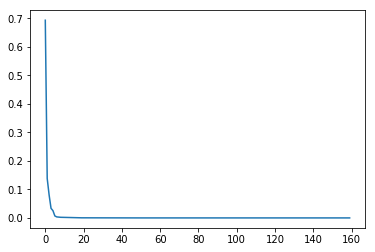

In [18]:
from sklearn.decomposition import PCA

X_train = train_data.iloc[:, 1:-1]
y_train = train_data.iloc[:, -1]

X_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1]

pca = PCA(n_components=train_data.shape[1]-2)
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_)

#### Note
* Less than 10 variables are responsible for all the variance
* Therefore will stick to 10 variables for machine learning portioins

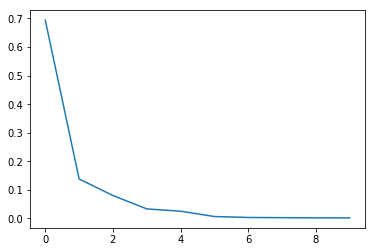

In [19]:
pca = PCA(n_components=10)
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

y_train = np.array(y_train)[:, np.newaxis]
y_test = np.array(y_test)[:, np.newaxis]

### Logistic Regression

In [20]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_hat_lr = lr.predict(X_test)
print(classification_report(y_test, y_hat_lr))

             precision    recall  f1-score   support

        0.0       0.77      1.00      0.87      4552
        1.0       0.89      0.04      0.08      1445

avg / total       0.80      0.77      0.68      5997



/Users/Anas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
print(confusion_matrix(y_test, y_hat_lr))

[[4544    8]
 [1383   62]]


#### Note
* Accuracy is about 76%
* Model is very weak at predicting cases of dangerous driving

In [22]:
folds = KFold(n_splits=10, shuffle=True, random_state=93)
hyperparams = {'C': [0.1, 1, 10, 100, 1000, 10000]}
est = LogisticRegression()
cv = GridSearchCV(estimator=est,
                  param_grid=hyperparams,
                  scoring=['accuracy', 'f1_weighted', 'precision'],
                  cv=folds,
                  return_train_score=True,
                  refit='f1_weighted')

cv.fit(X_train, y_train)

pd.DataFrame(cv.cv_results_)[['param_C', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_f1_weighted']]

In [23]:
# Since 10000 gave the best f1 score, set C=10000
lr = LogisticRegression(C=10000)
lr.fit(X_train, y_train)
y_hat_lr = lr.predict(X_test)
print(classification_report(y_test, y_hat_lr))

             precision    recall  f1-score   support

        0.0       0.78      0.98      0.87      4552
        1.0       0.65      0.11      0.19      1445

avg / total       0.75      0.77      0.70      5997



/Users/Anas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
print(confusion_matrix(y_test, y_hat_lr))

[[4468   84]
 [1288  157]]


### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifier = DecisionTreeClassifier(max_depth=5, criterion='gini')
classifier.fit(X_train, y_train)
y_hat_tree = classifier.predict(X_test)
print(classification_report(y_test, y_hat_tree))

/Users/Anas/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


             precision    recall  f1-score   support

        0.0       0.77      0.99      0.87      4552
        1.0       0.70      0.09      0.15      1445

avg / total       0.75      0.77      0.70      5997



In [26]:
print(confusion_matrix(y_test, y_hat_tree))

[[4498   54]
 [1321  124]]


#### Note
* Without much tuning a decision tree performs slightly better at identifying dangerous driving

In [27]:
hyperparams = {'criterion': ['gini', 'entropy'],
               'max_depth': [4, 5, 6, 7, 8, 9, 10],
               'min_samples_leaf': [1, 10, 50, 100]}
est = DecisionTreeClassifier()
cv = GridSearchCV(estimator=est,
                  param_grid=hyperparams,
                  scoring=['accuracy', 'f1_weighted', 'precision'],
                  verbose=1,
                  cv=folds,
                  return_train_score=True,
                  refit='f1_weighted')

cv.fit(X_train, y_train)

pd.DataFrame(cv.cv_results_)[['param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_f1_weighted']]

In [28]:
classifier = DecisionTreeClassifier(max_depth=8, criterion='entropy', min_samples_leaf=100)
classifier.fit(X_train, y_train)
y_hat_tree = classifier.predict(X_test)
print(classification_report(y_test, y_hat_tree))

             precision    recall  f1-score   support

        0.0       0.79      0.94      0.86      4552
        1.0       0.50      0.20      0.28      1445

avg / total       0.72      0.76      0.72      5997



In [29]:
print(confusion_matrix(y_test, y_hat_tree))

[[4267  285]
 [1160  285]]


In [30]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_hat_rf = classifier.predict(X_test)
print(classification_report(y_test, y_hat_rf))

/Users/Anas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


             precision    recall  f1-score   support

        0.0       0.78      0.94      0.85      4552
        1.0       0.47      0.16      0.24      1445

avg / total       0.71      0.75      0.71      5997



In [31]:
print(confusion_matrix(y_test, y_hat_rf))

[[4289  263]
 [1208  237]]


In [32]:
# import warnings
# warnings.filterwarnings('ignore')

# hyperparams = {'max_depth': [None, 4, 5, 6, 7, 8, 9, 10],
#                'min_samples_leaf': [1, 10, 50, 100]}
# est = RandomForestClassifier(criterion='entropy', n_estimators=100)
# cv = GridSearchCV(estimator=est,
#                   param_grid=hyperparams,
#                   scoring=['accuracy', 'f1_weighted', 'precision'],
#                   verbose=1,
#                   cv=folds,
#                   return_train_score=True,
#                   refit='f1_weighted')

# cv.fit(X_train, y_train)

# pd.DataFrame(cv.cv_results_)[['param_max_depth', 'param_min_samples_leaf', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_f1_weighted']]

In [33]:
classifier = RandomForestClassifier(criterion='entropy', n_estimators=10)
classifier.fit(X_train, y_train)
y_hat_rf = classifier.predict(X_test)
print(classification_report(y_test, y_hat_rf))

/Users/Anas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


             precision    recall  f1-score   support

        0.0       0.78      0.95      0.86      4552
        1.0       0.49      0.15      0.23      1445

avg / total       0.71      0.76      0.71      5997



In [34]:
print(confusion_matrix(y_test, y_hat_rf))

[[4324  228]
 [1223  222]]


### SVM

In [1]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(X_train, y_train)
y_hat_svm = classifier.predict(X_test)
print(classification_report(y_test, y_hat_svm))

NameError: name 'X_train' is not defined

In [36]:
print(confusion_matrix(y_test, y_hat_svm))

[[4552    0]
 [1445    0]]


In [37]:
# import warnings 
# warnings.filterwarnings('ignore')

# folds = KFold(n_splits=5, shuffle=True, random_state=93)
# hyperparams = {'C': [0.1, 1, 10, 100, 1000], 
#                'gamma': [1e-5, 1e-4, 1e-3, 1e-2]} 
# est = SVC(kernel='linear') 
# cv = GridSearchCV(estimator=est, 
#                   param_grid=hyperparams, 
#                   scoring=['accuracy', 'f1_weighted', 'precision'], 
#                   verbose=1, 
#                   cv=folds, 
#                   return_train_score=True, 
#                   refit='f1_weighted')

# cv.fit(X_train, y_train)

# res = pd.DataFrame(cv.cv_results_)
# res[['param_C', 'param_gamma', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_f1_weighted']]


In [38]:
# hyperparams = {'C': [0.1, 1, 10, 100, 1000], 
#                'gamma': [1e-5, 1e-4, 1e-3, 1e-2]} 
# est = SVC(kernel='rbf') 
# cv = GridSearchCV(estimator=est, 
#                   param_grid=hyperparams, 
#                   scoring=['accuracy', 'f1_weighted', 'precision'], 
#                   verbose=1, 
#                   cv=folds, 
#                   return_train_score=True, 
#                   refit='f1_weighted')

# cv.fit(X_train, y_train)

# res = pd.DataFrame(cv.cv_results_)
# res[['param_C', 'param_gamma', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_f1_weighted']]


In [39]:
# hyperparams = {'C': [0.1, 1, 10, 100, 1000], 
#                'gamma': [1e-5, 1e-4, 1e-3, 1e-2],
#                'degree': [3, 4]} 
# est = SVC(kernel='poly') 
# cv = GridSearchCV(estimator=est, 
#                   param_grid=hyperparams, 
#                   scoring=['accuracy', 'f1_weighted', 'precision'], 
#                   verbose=1, 
#                   cv=folds, 
#                   return_train_score=True, 
#                   refit='f1_weighted')

# cv.fit(X_train, y_train)

# res = pd.DataFrame(cv.cv_results_)
# res[['param_C', 'param_gamma', 'param_degree', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_f1_weighted']]


In [40]:
# hyperparams = {'C': [0.1, 1, 10, 100, 1000], 
#                'gamma': [1e-5, 1e-4, 1e-3, 1e-2]} 
# est = SVC(kernel='sigmoid') 
# cv = GridSearchCV(estimator=est, 
#                   param_grid=hyperparams, 
#                   scoring=['accuracy', 'f1_weighted', 'precision'], 
#                   verbose=1, 
#                   cv=folds, 
#                   return_train_score=True, 
#                   refit='f1_weighted')

# cv.fit(X_train, y_train)

# res = pd.DataFrame(cv.cv_results_)
# res[['param_C', 'param_gamma', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_f1_weighted']]


### Gradient Boosting

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
y_hat_grad = classifier.predict(X_test)
print(classification_report(y_test, y_hat_grad))

/Users/Anas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

        0.0       0.78      0.98      0.87      4552
        1.0       0.64      0.13      0.22      1445

avg / total       0.75      0.77      0.71      5997



In [42]:
print(confusion_matrix(y_test, y_hat_grad))

[[4447  105]
 [1255  190]]


In [43]:
# hyperparams = {'learning_rate': [1e-3, 1e-2, 1e-1],
#                'subsample': [0.6, 0.7, 0.8, 1.0],
#                'min_samples_split': [2, 10, 50]} 
# est = GradientBoostingClassifier()
# cv = GridSearchCV(estimator=est, 
#                   param_grid=hyperparams, 
#                   scoring=['accuracy', 'f1_weighted', 'precision'], 
#                   verbose=1, 
#                   cv=folds, 
#                   return_train_score=True, 
#                   refit='f1_weighted')

# cv.fit(X_train, y_train)

# res = pd.DataFrame(cv.cv_results_)
# res[['param_learning_rate', 'param_subsample', 'param_min_samples_split','mean_test_precision', 'mean_test_accuracy', 'mean_test_f1_weighted']]

In [44]:
classifier = GradientBoostingClassifier(subsample=0.7, min_samples_split=10)
classifier.fit(X_train, y_train)
y_hat_grad = classifier.predict(X_test)
print(classification_report(y_test, y_hat_grad))

/Users/Anas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

        0.0       0.78      0.97      0.87      4552
        1.0       0.62      0.15      0.24      1445

avg / total       0.74      0.77      0.71      5997



In [45]:
print(confusion_matrix(y_test, y_hat_grad))

[[4422  130]
 [1234  211]]


#### Note
* New models will be created using the training set and be appended as new data collumns
* Same will be done for the test set

In [46]:
model1 = LogisticRegression(C=10000).fit(X_train, y_train)
model2 = DecisionTreeClassifier(max_depth=8, criterion='entropy', min_samples_leaf=100).fit(X_train, y_train)
model3 = RandomForestClassifier(criterion='entropy', n_estimators=10).fit(X_train, y_train)
model4 = SVC(probability=True).fit(X_train, y_train)
model5 = GradientBoostingClassifier(subsample=0.7, min_samples_split=10).fit(X_train, y_train)

/Users/Anas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Anas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
def get_mod(array, models = [model1, model2, model3, model4, model5]):
    final_model = array
    for i in models:
        final_model = np.concatenate((final_model, i.predict_proba(array)[:, 0:1]), axis=1)
        
    return final_model

In [48]:
new_X_train = get_mod(X_train)

In [49]:
new_X_test = get_mod(X_test)

#### Note
* The function below will help to split the safe and unsafe results
* So that an equal number of safe and unsafe observations can be used in the batches
* This will improve the training of the neural network a stated in Yann Lecun's paper

In [50]:
def split_data(X, y):
    """Splits data based on classifier 0 and 1"""
    data = np.concatenate((X, y), axis=1)
    zero = data[(data[:, -1]==0)][:, 0:15]
    one = data[(data[:, -1]==1)][:, 0:15]
    
    return (zero, one)

In [51]:
def prep_batch(batch_size, array1, array2):
    holder = []
    zero = np.random.randint(array1.shape[0], size=16)
    one = np.random.randint(array2.shape[0], size=16)
    for i in range(batch_size//2):
        holder.append(array1[zero[i]:zero[i]+1, :])
        holder.append(array2[one[i]:one[i]+1, :])
        
    return np.concatenate(holder, axis=0)

In [52]:
prep_batch(32, split_data(new_X_train, y_train)[0], split_data(new_X_train, y_train)[1])

array([[ 4.04991769e-02,  2.87145949e-02, -8.48360033e-03,
         1.42991195e-03, -2.42677207e-03, -2.33973780e-03,
         5.18448077e-03, -7.74234764e-03,  4.38970147e-03,
        -5.16427203e-03,  8.57327595e-01,  7.59036145e-01,
         1.00000000e+00,  7.73847332e-01,  8.47262924e-01],
       [-5.90632089e-02,  4.92090332e-03, -1.12978940e-02,
        -4.85818640e-03,  5.30457850e-03,  3.57988397e-03,
        -1.94893076e-03,  1.34843397e-03, -3.83207568e-03,
         3.46063582e-04,  8.53518615e-01,  7.24137931e-01,
         4.00000000e-01,  6.63072848e-01,  8.31105726e-01],
       [ 9.64101706e-03, -3.10488698e-02, -4.62902166e-03,
         1.32917537e-05,  9.07917314e-04, -3.78824570e-04,
         1.45702212e-04, -1.53296997e-03, -2.79689093e-05,
         2.85308030e-04,  6.49803901e-01,  7.49385749e-01,
         1.00000000e+00,  7.13796638e-01,  6.19558583e-01],
       [-4.99254050e-02, -9.21627788e-03, -5.97962300e-03,
        -4.41628841e-03,  7.76928875e-03,  1.88660336

### Neural Network

In [53]:
def init_weight(shape):
    weights = tf.truncated_normal(shape, stddev=0.1)
    # Truncated normal will pick values from normal distribution, but if the value
    # is off by 2 std dev, the value is dropped and repicked.
    return tf.Variable(weights)

In [54]:
def init_bias(shape):
    bias = tf.constant(0.1, shape=shape)
    return tf.Variable(bias)

In [55]:
def layer(input_layer, size):
    # The number of size determines the number of neurons on the next layer
    input_size = int(input_layer.get_shape()[1])
    W = init_weight([input_size, size])
    b = init_bias([size])
  
    return tf.matmul(input_layer, W) + b

In [56]:
x = tf.placeholder(tf.float32, shape=[None, 15]) 
y_true = tf.placeholder(tf.float32, shape=[None,1])

In [57]:
hold_prob = tf.placeholder(tf.float32)
dropout_layer = tf.nn.dropout(x, rate=1-hold_prob)

In [58]:
hidden_layer1 = tf.nn.leaky_relu(layer(dropout_layer, 10))

Instructions for updating:
Colocations handled automatically by placer.


In [59]:
hidden_layer2 = tf.nn.leaky_relu(layer(hidden_layer1, 5))

In [60]:
y_hat = tf.nn.softmax(layer(hidden_layer2, 1))

In [61]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y_hat))

In [62]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [63]:
init = tf.global_variables_initializer()

In [ ]:
steps = 1001
batch_size=32
with tf.Session() as sess:
    sess.run(init)
    zero, one = split_data(new_X_train, y_train) 
    batch_y = np.array([[0,1]]*16).flatten()[:, np.newaxis]
    for i in range(steps):
        print(i)
        batch_x = prep_batch(batch_size, zero, one)
        sess.run(train, feed_dict={x:batch_x, y_true:batch_y, hold_prob:0.8})
        # Every 100 steps check the accuracy
        if i%100 == 0:
            acc = tf.metrics.accuracy(y_true, y_hat)
            res = sess.run(acc, feed_dict={x:new_X_test,
                                           y_true:y_test,
                                           hold_prob:1})
            print('Step {}, Accuraccy {}'.format(i, res))

0
